## Assignment 5 - Python

Setup

In [127]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp
from sympy.solvers import solve
from bs4 import BeautifulSoup
import requests
from sklearn.linear_model import LinearRegression

from cycler import cycler
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pylab as pylab


# custome plot style
params  = {
"lines.linewidth": 1.5,

"legend.fancybox": "true",

"axes.prop_cycle": cycler('color', ["#ffa822","#1ac0c6","#ff6150","#30B66A","#B06AFF","#FF21E1"]),
"axes.facecolor": "#2b2b2b",
"axes.axisbelow": "true",
"axes.grid": "true",
"axes.edgecolor": "#2b2b2b",
"axes.linewidth": 0.5,
"axes.labelpad": 0,

"patch.edgecolor": "#2b2b2b",
"patch.linewidth": 0.5,

"grid.linestyle": "--",
"grid.linewidth": 0.5,
"grid.color": "#b8aba7",

"xtick.major.size": 0,
"xtick.minor.size": 0,
"ytick.major.size": 0,
"ytick.minor.size": 0,

"font.family":"monospace",
"font.size":10.0,
"text.color": "#FFE9E3",
"axes.labelcolor": "#b8aba7",
"xtick.color": "#b8aba7",
"ytick.color": "#b8aba7",

"savefig.edgecolor": "#2b2b2b",
"savefig.facecolor": "#2b2b2b",

"figure.subplot.left": 0.08,
"figure.subplot.right": 0.95,
"figure.subplot.bottom": 0.09,
"figure.facecolor": "#2b2b2b"}

pylab.rcParams.update(params)
print("finish")

finish


Get and clean data

In [128]:
# Collect data from website, with BeautifulSoup4
def fetch_tables_from_website(url):
    response = requests.get(url)
    soup_content = BeautifulSoup(response.content, "html.parser")
    tables = soup_content.find_all("table")
    return tables

# Takes the raw data from BeautifulSoup, and creates a table (with some header settings)
def table_to_dataframe(table,use_first_row_as_header:bool = False):
    header = [th.get_text(strip=True) for th in table.find_all("th")]
    
    if use_first_row_as_header:
        first_row = table.find("tr")
        header = [td.get_text(strip=True) for td in first_row.find_all("td")]
        first_row.extract()
    elif not header:
        num_columns = len(table.find("tr").find_all("td"))
        header = [f"Column{i+1}" for i in range(num_columns)]
    
    table_data = []
    for row in table.find_all("tr"):
        row_data = [td.get_text(strip=True) for td in row.find_all("td")]
        if row_data:
            table_data.append(row_data)
    df = pd.DataFrame(table_data, columns=header)
    return df

# Clean the data, remve None
def remove_na(df, na_symbols=['NA']):
    df_cleaned = df.copy()
    for symbol in na_symbols:
        df_cleaned.replace(symbol, None, inplace=True)
    return df_cleaned.dropna()

# Change and configurate column 
def process_column(df, column, new_column_name, replacements={}, new_dtype=None):
    df_processed = df.copy()
    
    for old_text, new_text in replacements.items():
        df_processed[column] = df_processed[column].astype(str).str.replace(old_text, new_text)
    
    if new_dtype is not None:
        df_processed[column] = df_processed[column].astype(new_dtype)
    
    df_processed.rename(columns={column: new_column_name}, inplace=True)
    return df_processed

url = 'https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132'
tables = fetch_tables_from_website(url)
table_index = 0
selected_table = tables[table_index]
df_raw = table_to_dataframe(selected_table,True)

df_cleaned = remove_na(df_raw, na_symbols=['x'])
print(df_cleaned)

   Modell (temp. varierte fra 0° til -10°)        WLTP-tall   STOPP     Avvik
0              Tesla Model 3 LR Dual motor  614 km/14,7 kWh  521 km  -15,15 %
1             Mercedes-Benz EQS 580 4matic  645 km/18,3 kWh  513 km  -20,47 %
2                          BMW iX xDrive50  591 km/21,4 kWh  503 km  -14,89 %
3              Tesla Model Y LR Dual motor  507 km/16,9 kWh  451 km  -11,05 %
4                    Volkswagen ID.3 PRO S  539 km/16,3 kWh  435 km  -19,29 %
5                              Kia EV6 2WD  528 km/16,5 kWh  429 km  -18,75 %
6                       NIO ES8 LR 7-seter  488 km/21,5 kWh  425 km  -12,91 %
7                              Kia EV6 4WD  484 km/18,0 kWh  423 km  -12,60 %
8                      Volkswagen ID.4 Pro  485 km/18,4 kWh  414 km  -14,64 %
9                      Hyundai Ioniq 5 2WD  481 km/16,8 kWh  408 km  -15,18 %
10                              BMW i4 M50  497 km/19,0 kWh  406 km  -18,31 %
11                       Skoda Enyaq iV80X  477 km/18,2 kWh  403

In [129]:
df = df_cleaned
df[['KM', 'Energy']] = df['WLTP-tall'].str.split('km/', expand=True)

df['KM'] = df['KM'].str.rstrip(' km')
df['Energy'] = df['Energy'].str.rstrip(' kWh')

df['KM'] = pd.to_numeric(df['KM'], errors='coerce')
df['Energy'] = pd.to_numeric(df['Energy'].str.replace(',', '.'), errors='coerce')

df = df.drop(columns=['WLTP-tall'])

df = process_column(df, 'STOPP', 'STOPP(KM)', replacements={'km': ''}, new_dtype=float)
print(df)

   Modell (temp. varierte fra 0° til -10°)  STOPP(KM)     Avvik   KM  Energy
0              Tesla Model 3 LR Dual motor      521.0  -15,15 %  614    14.7
1             Mercedes-Benz EQS 580 4matic      513.0  -20,47 %  645    18.3
2                          BMW iX xDrive50      503.0  -14,89 %  591    21.4
3              Tesla Model Y LR Dual motor      451.0  -11,05 %  507    16.9
4                    Volkswagen ID.3 PRO S      435.0  -19,29 %  539    16.3
5                              Kia EV6 2WD      429.0  -18,75 %  528    16.5
6                       NIO ES8 LR 7-seter      425.0  -12,91 %  488    21.5
7                              Kia EV6 4WD      423.0  -12,60 %  484    18.0
8                      Volkswagen ID.4 Pro      414.0  -14,64 %  485    18.4
9                      Hyundai Ioniq 5 2WD      408.0  -15,18 %  481    16.8
10                              BMW i4 M50      406.0  -18,31 %  497    19.0
11                       Skoda Enyaq iV80X      403.0  -15,51 %  477    18.2

Plot:

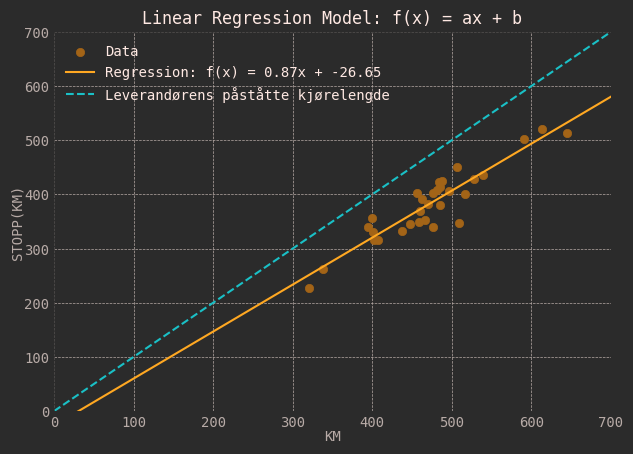

In [131]:
r_size = [0,700]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['KM'], df['STOPP(KM)'])

# Create plot
fig, ax = plt.subplots()
ax.scatter(df['KM'], df['STOPP(KM)'], label='Data', color = "#a36417")

y = [slope * xi + intercept for xi in r_size]
ax.plot(r_size, y, label=f'Regression: f(x) = {slope:.2f}x + {intercept:.2f}')

ax.plot(r_size, r_size, linestyle='--', label="Leverandørens påståtte kjørelengde")

ax.set_xlabel('KM')
ax.set_ylabel('STOPP(KM)')
ax.set_title('Linear Regression Model: f(x) = ax + b')
ax.set_xlim(r_size[0], r_size[1])
ax.set_ylim(r_size[0], r_size[1])
ax.legend(loc='best',frameon=False)

plt.show()